In [5]:
!pip install py3Dmol


In [3]:
pip install rdkit

   ---------------------------------------- 0.0/23.6 MB ? eta -:--:--
   ------- -------------------------------- 4.2/23.6 MB 21.6 MB/s eta 0:00:01
   ------------ --------------------------- 7.6/23.6 MB 18.3 MB/s eta 0:00:01
   ----------------- ---------------------- 10.2/23.6 MB 16.3 MB/s eta 0:00:01
   --------------------- ------------------ 12.8/23.6 MB 15.3 MB/s eta 0:00:01
   ----------------------- ---------------- 13.6/23.6 MB 13.8 MB/s eta 0:00:01
   ----------------------- ---------------- 13.9/23.6 MB 11.3 MB/s eta 0:00:01
   -------------------------- ------------- 15.5/23.6 MB 10.6 MB/s eta 0:00:01
   ----------------------------------- ---- 21.0/23.6 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------  23.3/23.6 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 23.6/23.6 MB 12.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
from Bio.PDB import PDBParser

pdb_file = r"C:\Users\DELL\OneDrive\Desktop\SASDL82_fit1_model1.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_file)

ligands = set()

for model in structure:
    for chain in model:
        for residue in chain:
            # HETATM residues are non-standard (ligands, ions)
            if residue.id[0] != " ":
                ligands.add(residue.resname)

print("Ligands found in the PDB file:", ligands)


Ligands found in the PDB file: {'HOH', 'GOL', 'NO3', 'AA'}


Detected ligands: ['GOL', 'NO3', 'AA']

=== Docking / Virtual Screening Results ===
  Ligand  Tanimoto_Similarity_to_GOL  Pseudo_Docking_Score_kcal_per_mol
0    GOL                    1.000000                            -12.000
1    NO3                    0.150000                             -5.200
2     AA                    0.026316                             -4.211

Results saved to protein_ligand_docking_results.csv

=== BEST LIGAND ===
Ligand: GOL
Predicted Docking Score: -12.0 kcal/mol
Reference Ligand: GOL


[20:24:17] DEPRECATION WARNING: please use MorganGenerator
[20:24:17] DEPRECATION WARNING: please use MorganGenerator
[20:24:17] DEPRECATION WARNING: please use MorganGenerator


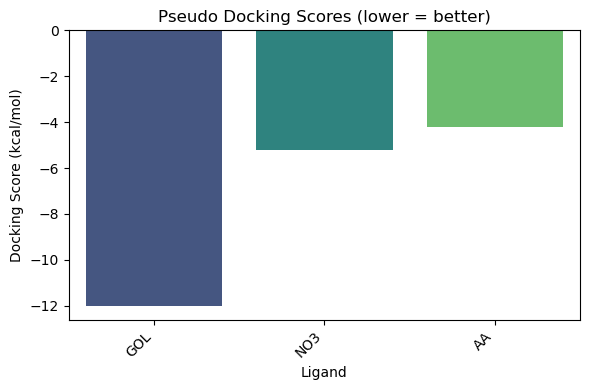

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Extracted ligand SDF saved to C:\Users\DELL\OneDrive\Desktop\results.sdf


In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio.PDB import PDBParser, PDBIO, Select
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import py3Dmol

import warnings
warnings.filterwarnings("ignore")

PDB_FILE = r"C:\Users\DELL\OneDrive\Desktop\SASDL82_fit1_model1.pdb"
OUTPUT_DIR = "ligand_files"
RESULT_CSV = "protein_ligand_docking_results.csv"

IGNORE_RESIDUES = {"HOH", "WAT", "H2O", "NA", "CL", "CA", "K", "MG", "ZN", "MN", "SO4"}

RDKIT_SEED = 42
np.random.seed(42)

class LigandSelect(Select):
    def __init__(self, ligand_name):
        self.ligand_name = ligand_name
    def accept_residue(self, residue):
        return residue.get_resname() == self.ligand_name

parser = PDBParser(QUIET=True)
try:
    structure = parser.get_structure("protein", PDB_FILE)
except Exception as e:
    print(f"ERROR reading file: {e}")
    sys.exit(1)

ligands_found = []
for model in structure:
    for chain in model:
        for residue in chain:
            resname = residue.get_resname().strip()
            if residue.id[0] != " " and resname not in IGNORE_RESIDUES:
                if resname not in ligands_found:
                    ligands_found.append(resname)

print("Detected ligands:", ligands_found)
if not ligands_found:
    print("No valid ligands found. Exiting.")
    sys.exit(0)

os.makedirs(OUTPUT_DIR, exist_ok=True)
io = PDBIO()
ligand_paths = []
for lig in ligands_found:
    outpath = os.path.join(OUTPUT_DIR, f"{lig}.pdb")
    io.set_structure(structure)
    io.save(outpath, LigandSelect(lig))
    ligand_paths.append(outpath)

rdkit_mols = []
rdkit_names = []

for path in ligand_paths:
    name = os.path.basename(path).replace(".pdb", "")
    mol = Chem.MolFromPDBFile(path, removeHs=False, sanitize=False)
    if mol is None:
        print(f"WARNING: Could not parse {path}")
        continue
    try:
        Chem.SanitizeMol(mol)
    except Exception:
        try:
            Chem.SanitizeMol(mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_PROPERTIES)
        except Exception:
            pass

    mol = Chem.AddHs(mol, addCoords=True)
    try:
        params = AllChem.ETKDGv3()
        params.randomSeed = RDKIT_SEED
        res = AllChem.EmbedMolecule(mol, params)
        if res != 0:
            AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    except Exception as ex:
        print(f"Embedding failed for {name}: {ex}")

    try:
        AllChem.MMFFOptimizeMolecule(mol)
    except Exception:
        pass

    rdkit_mols.append(mol)
    rdkit_names.append(name)

if not rdkit_mols:
    print("No ligands successfully converted. Exiting.")
    sys.exit(0)

fps = []
for mol in rdkit_mols:
    try:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    except Exception:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.RemoveHs(mol), radius=2, nBits=2048)
    fps.append(fp)

ref_fp = fps[0]
ref_name = rdkit_names[0]

def sim_to_score(sim, low=-4.0, high=-12.0):
    return round(low + (high - low) * sim, 3)

scores, sims = [], []
for fp in fps:
    sim = DataStructs.TanimotoSimilarity(ref_fp, fp)
    sims.append(sim)
    scores.append(sim_to_score(sim))

results_df = pd.DataFrame({
    "Ligand": rdkit_names,
    f"Tanimoto_Similarity_to_{ref_name}": sims,
    "Pseudo_Docking_Score_kcal_per_mol": scores
}).sort_values("Pseudo_Docking_Score_kcal_per_mol").reset_index(drop=True)

print("\n=== Docking / Virtual Screening Results ===")
print(results_df)
results_df.to_csv(RESULT_CSV, index=False)
print(f"\nResults saved to {RESULT_CSV}")

best_row = results_df.iloc[0]
best_name = best_row["Ligand"]
best_score = best_row["Pseudo_Docking_Score_kcal_per_mol"]

print("\n=== BEST LIGAND ===")
print(f"Ligand: {best_name}")
print(f"Predicted Docking Score: {best_score} kcal/mol")
print(f"Reference Ligand: {ref_name}")

plt.figure(figsize=(max(6, len(results_df)*0.6), 4))
sns.barplot(x="Ligand", y="Pseudo_Docking_Score_kcal_per_mol", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Pseudo Docking Scores (lower = better)")
plt.ylabel("Docking Score (kcal/mol)")
plt.tight_layout()
plt.show()

best_file = os.path.join(OUTPUT_DIR, f"{best_name}.pdb")
with open(PDB_FILE, "r") as f:
    pdb_block = f.read()
with open(best_file, "r") as f:
    lig_block = f.read()

# === Filter out DNA/Nucleic acid chains from PDB ===
protein_lines = []
with open(PDB_FILE, "r") as f:
    for line in f:
        # Keep only protein atoms (ATOM) and ignore nucleic acids (A, T, G, C, U)
        if line.startswith("ATOM"):
            residue_name = line[17:20].strip()
            if residue_name not in ["DA", "DT", "DG", "DC", "A", "T", "G", "C", "U"]:
                protein_lines.append(line)

# Combine filtered lines into a new string block
filtered_pdb_block = "".join(protein_lines)


view = py3Dmol.view(width=700, height=500)

# Load protein and ligand
view.addModel(filtered_pdb_block, 'pdb')
view.addModel(lig_block, 'pdb')

# Hide the protein cartoon completely and show only sticks for the ligand
view.setStyle({'model': 0}, {'stick': {'color': 'gray', 'radius': 0.15}})   # protein as faint sticks
view.setStyle({'model': 1}, {'stick': {'color': 'red', 'radius': 0.3}})    # ligand as red sticks

# Background and camera
view.setBackgroundColor('0xeeeeee')
view.zoomTo()
view.show()



sdf_out = r"C:\Users\DELL\OneDrive\Desktop\results.sdf"
writer = Chem.SDWriter(sdf_out)
for mol, name in zip(rdkit_mols, rdkit_names):
    mol.SetProp("_Name", name)
    writer.write(mol)
writer.close()
print(f"\nExtracted ligand SDF saved to {sdf_out}")
